<a href="https://colab.research.google.com/github/lg960214/DACON_Seoul_6/blob/develop/Geo_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas #geopandas
!pip install xlrd==1.2.0 #xls 읽기 위해
!pip install rtree pygeos
!pip install pydeck
#matplotlib 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/libe

In [2]:
#필수 패키지 임포트
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import os
import pydeck as pdk
import matplotlib.font_manager as fm 
import matplotlib as mpl
#fm._rebuild() 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [3]:
def read_df(y=2022, m=9, sheet=2): #sheet 2는 월별 무임유임 승하차 데이터, sheet3은 일별시간별 승하차데이터, 4는 노인 일별 시간대별 승하차 데이터. 5는 행정동 단위 인구 거주
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트 경로
  dir_subway_eld = '/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv'
  dir_live = '/content/drive/MyDrive/DACON6/서울시 인구 거주/서울시 행정동 단위 생활인구' #서울 행정동 단위 인구 거주

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.

  #어떤 df 읽을지
  if sheet < 4:
    for year in os.listdir(rootdir):
      sub_sub_dirs = {}
      for month in os.listdir(os.path.join(rootdir, year)):
        sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
      sub_dirs[int(year)] = sub_sub_dirs
    df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')
  elif sheet==4:
    df = pd.read_csv(dir_subway_eld, encoding='cp949')
  elif sheet==5:
    df = pd.read_csv(dir_live+f"/LOCAL_PEOPLE_DONG_{y}{'0' if m < 10 else ''}{m}.csv")

  #df 마다 어떤 전처리 거칠 건지
  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  elif sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  elif sheet==4:
    df = df.drop(columns=['연번', '역번호', '구분'])
    df['연월'] = df['일자'].apply(lambda x : '-'.join(x.split('-')[:2]))
    df = df[df['연월']==f"{y}-{'0' if m < 10 else ''}{m}"]
    df = df.groupby(by='역명').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  elif sheet==5:
    pass
  return df

In [4]:
def to_geodf(df, epsg=5179):
  dir_station = '/content/drive/MyDrive/DACON6/지하철 시설 정보/서울시 역사마스터 정보.csv' #역 좌표 데이터
  df_station = pd.read_csv(dir_station, encoding='cp949')
  df_station = df_station.drop(columns=['역사_ID', '호선'])
  df_station = df_station.groupby(by='역사명').mean()
  df_station['지하철역'] = df_station.index
  df_station.index = list(range(len(df_station))) #읽어와서 필요없는 컬럼 지우고 중복되는 역은 좌표를 평균냄

  df = pd.merge(df, df_station, on='지하철역') #역 좌표 데이터를 승하차 데이터와 통합

  s = gpd.GeoSeries([Point(x, y) for x, y in zip(df['위도'], df['경도'])]) #위도 경도 데이터를 GeoSeries Point 로 변환
  
  geodf = gpd.GeoDataFrame(df, geometry=s) # GeoDataFrame 생성
  geodf.crs = 'epsg:4326' #현재 좌표계는 위도경도(epsg4326)
  geodf = geodf.to_crs(epsg=epsg) #경계 데이터 좌표계는(epsg5179) 이걸로 변환
  geodf = geodf.drop(columns=['위도', '경도']) #기존 위도 경도는 제거
  
  return geodf

In [5]:
def to_density(geodf): #True 일 경우 geojson 파일로 리턴
  geodf = geodf.drop(columns=['지하철역'])

  dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp' #.shp 파일 경로(서울시 행정구역 단위 경계 데이터)
  seoul = gpd.read_file(dir_shp) #경계 데이터 읽기
  seoul.crs = 'epsg:5179' # 좌표계

  temp = []
  #geodf을 통해 경계 구역 내 지하철 역의 데이터를 모두 더해 밀도로 변환
  station_pos = geodf.geometry
  for i, g in enumerate(seoul.geometry):
    idx = station_pos.within(g)
    temp.append(geodf[idx].iloc[:, :-1].sum().to_numpy().T)

  temp = np.stack(temp)
  c = geodf.columns[:-1]
  for i, col in enumerate(c):
    seoul[col] = temp[:, i]

  seoul = seoul.to_crs(epsg=4326)

  return seoul, seoul.to_json()

In [6]:
cmap='Blues'
edgecolor='black'

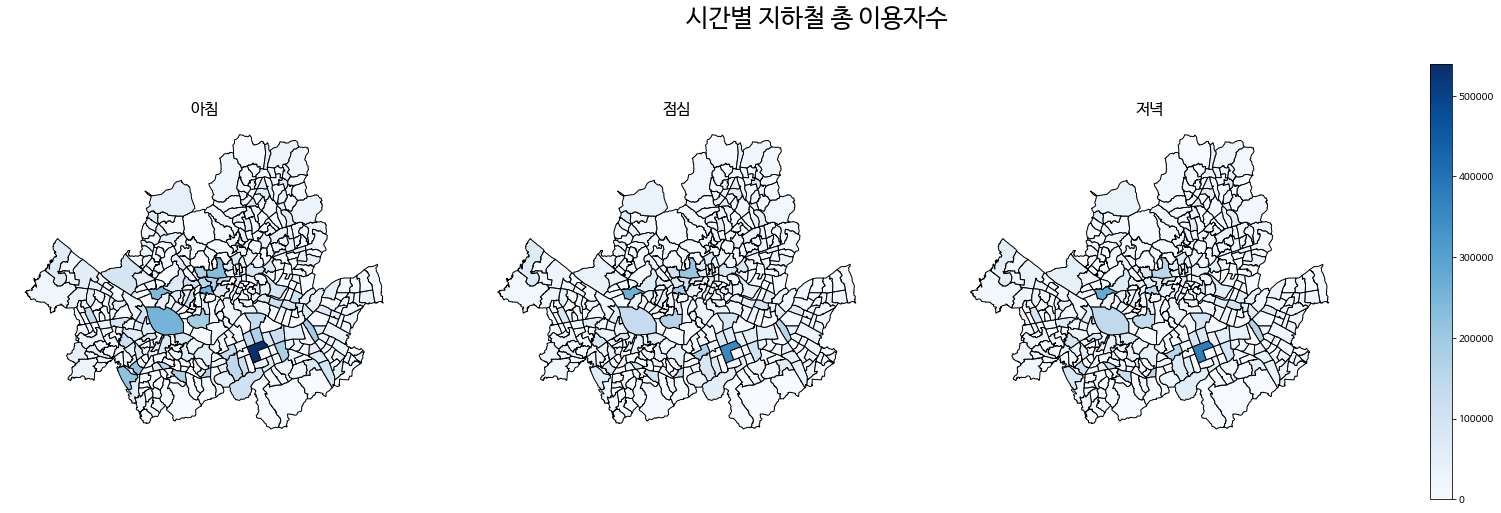

In [7]:
#시간대별 전체 승하차
df = read_df(2022, 5, 3)

time_dict = {'아침승하차':['7시승차', '8시승차', '7시하차', '8시하차'], '점심승하차':['14시승차','15시승차', '14시하차','15시하차'],'저녁승하차':['18시승차', '19시승차', '18시하차', '19시하차']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('시간별 지하철 총 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('아침', fontsize=16)
seoul.plot('아침승하차', ax=axs[0], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[1].axis('off')
axs[1].set_title('점심', fontsize=16)
seoul.plot('점심승하차', ax=axs[1], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[2].axis('off')
axs[2].set_title('저녁', fontsize=16)
seoul.plot('저녁승하차', ax=axs[2], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs)

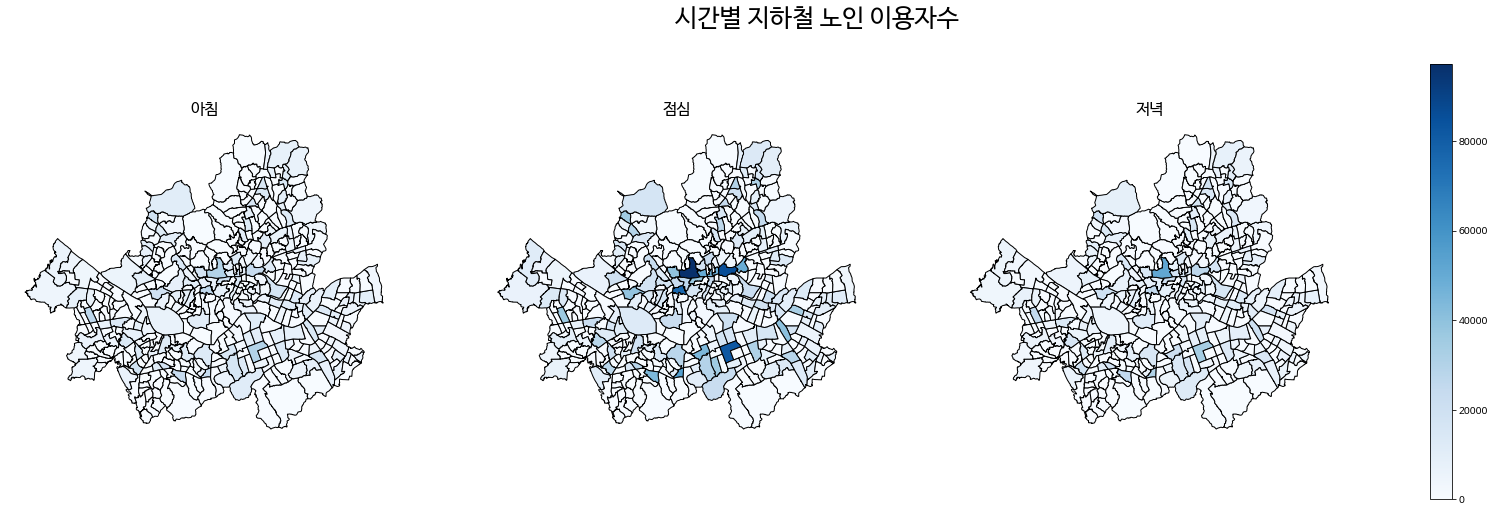

In [8]:
#노인 이용자의 시간별 밀도 자료
df = read_df(2022, 5, 4)
time_dict = {'아침승하차':['07시-08시', '08시-09시'], '점심승하차':['14시-15시', '15시-16시'],'저녁승하차':['18시-19시', '19시-20시']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('시간별 지하철 노인 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('아침', fontsize=16)
seoul.plot('아침승하차', ax=axs[0], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[1].axis('off')
axs[1].set_title('점심', fontsize=16)
seoul.plot('점심승하차', ax=axs[1], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[2].axis('off')
axs[2].set_title('저녁', fontsize=16)
seoul.plot('저녁승하차', ax=axs[2], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs)

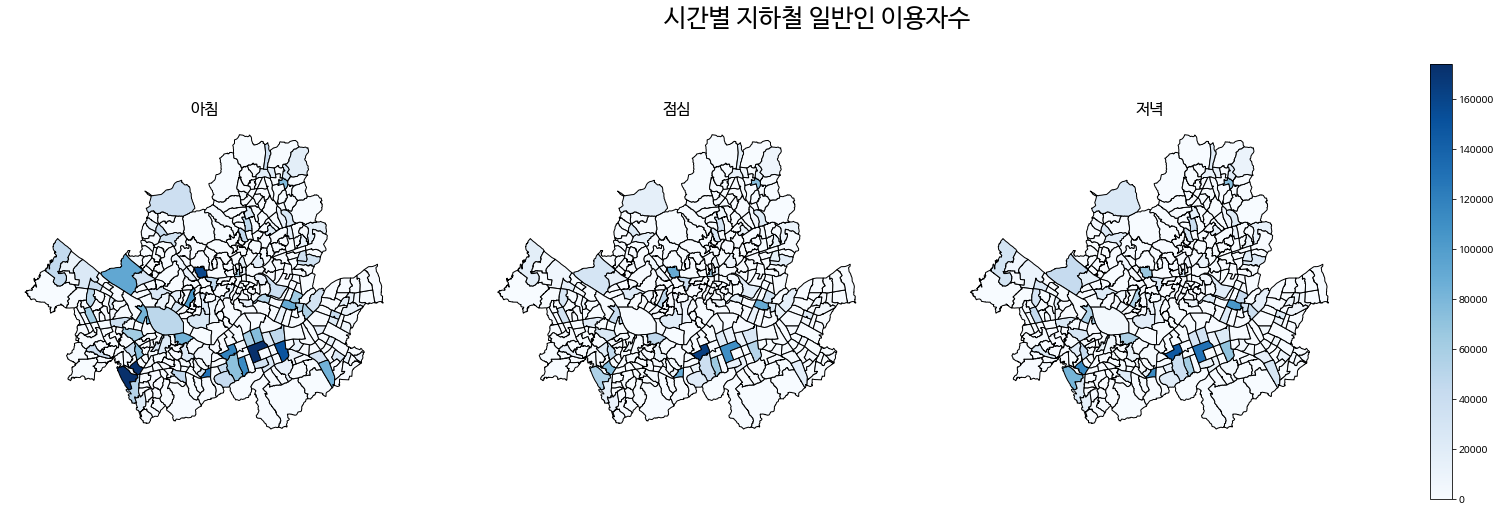

In [9]:
#일반인 이용자의 시간별 밀도 자료
df1 = read_df(2022, 5, 3)

time_dict = {'아침승하차':['7시승차', '8시승차', '7시하차', '8시하차'], '점심승하차':['14시승차','15시승차', '14시하차','15시하차'],'저녁승하차':['18시승차', '19시승차', '18시하차', '19시하차']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df1[s] = df1[time_dict[s]].mean(axis=1)

df2 = read_df(2022, 5, 4)
time_dict = {'아침승하차':['07시-08시', '08시-09시'], '점심승하차':['14시-15시', '15시-16시'],'저녁승하차':['18시-19시', '19시-20시']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df2[s] = df2[time_dict[s]].mean(axis=1)

df = df1.copy()

for s in ['아침승하차','점심승하차', '저녁승하차']:
  df[s] = df1[s] - df2[s]

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('시간별 지하철 일반인 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('아침', fontsize=16)
seoul.plot('아침승하차', ax=axs[0], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[1].axis('off')
axs[1].set_title('점심', fontsize=16)
seoul.plot('점심승하차', ax=axs[1], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[2].axis('off')
axs[2].set_title('저녁', fontsize=16)
seoul.plot('저녁승하차', ax=axs[2], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs)

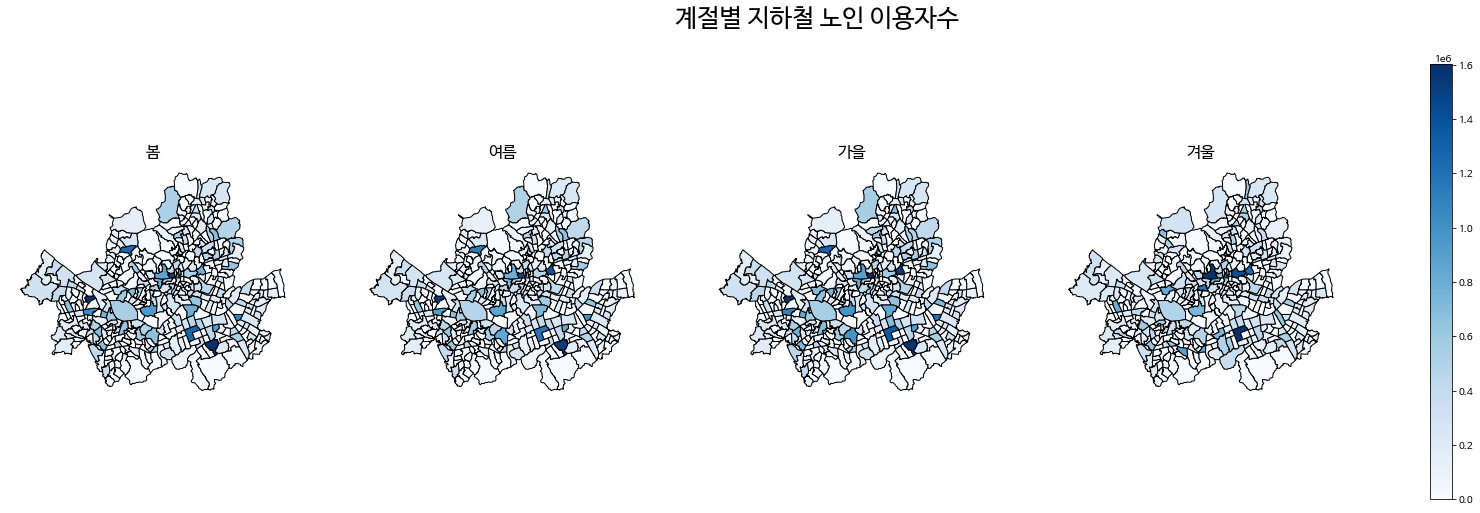

In [10]:
#계절 간의 노인 지하철 이용 밀도 그래프
season_dict = {'봄':[4, 5], '여름':[7, 8], '가을':[10, 11], '겨울':[1, 2]}
df = read_df(2021, 1, 2)

for key in season_dict:
    d1= read_df(2021, season_dict[key][0], 2)
    d2 = read_df(2021, season_dict[key][1], 2)
    df[key] = d1['무임승차'] + d1['무임하차'] + d2['무임승차'] + d2['무임하차']

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['봄'].max(), seoul['여름'].max(), seoul['가을'].max(), seoul['겨울'].max()]) * 0.9

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 4, figsize=(30, 8))
fig.suptitle('계절별 지하철 노인 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('봄', fontsize=16)
seoul.plot('봄', ax=axs[0], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[1].axis('off')
axs[1].set_title('여름', fontsize=16)
seoul.plot('여름', ax=axs[1], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[2].axis('off')
axs[2].set_title('가을', fontsize=16)
seoul.plot('가을', ax=axs[2], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

axs[3].axis('off')
axs[3].set_title('겨울', fontsize=16)
seoul.plot('겨울', ax=axs[3], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs)

In [ ]:
dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp' #.shp 파일 경로(서울시 행정구역 단위 경계 데이터)

seoul = gpd.read_file(dir_shp)
seoul = seoul.astype({'ADM_CD':'int64'})

dir_code = '/content/drive/MyDrive/DACON6/서울시 지리 정보/행정동코드_매핑정보.xlsx'
cd = pd.read_excel(dir_code).iloc[1:, :2]
cd_to_cd = {}
for row in cd.itertuples():
  cd_to_cd[int(row.행자부행정동코드)] = row.통계청행정동코드

target_erred = ['남자35세부터39세생활인구수', '남자40세부터44세생활인구수', '여자35세부터39세생활인구수', '여자40세부터44세생활인구수']
target = ['남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '여자60세부터64세생활인구수', '여자65세부터69세생활인구수']

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 5, figsize=(30, 10))
fig.suptitle('연도별 노인 인구분포', fontsize=25)

vm = 100000

dff = None
for i, year in enumerate([2017, 2018, 2019, 2020, 2021]):
  temp = []
  for month in range(1, 13):
    try:
      data = None
      df = read_df(year, month, 5)
      if type(df.index)!=pd.MultiIndex: #제대로 읽혔을 때
        df = df.groupby(by='시간대구분').mean()
        data = df[target].to_numpy()
      else: #인덱스 오류 났을 때
        df = df.reset_index().groupby(by='level_2').mean()
        data = df[target_erred].to_numpy()
      data = np.mean(data, axis=0)
      data = np.sum(data, axis=1)
      temp.append(data)
    except:
      pass

  dff = read_df(2017, 1, 5).reset_index().groupby(by='level_2').mean()
  dff['인구'] = np.mean(temp, axis=0)
  dff['ADM_CD'] = dff.index
  dff.index = list(range(len(dff)))
  dff['ADM_CD'] = dff['ADM_CD'].map(lambda x : cd_to_cd[x])
  merged = pd.merge(seoul, dff, on='ADM_CD')

  axs[i].axis('off')
  axs[i].set_title(f'{year}년도', fontsize=16)
  merged.plot('인구', ax=axs[i], vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)
  
norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **

In [12]:
target = ['남자35세부터39세생활인구수', '남자40세부터44세생활인구수', '여자35세부터39세생활인구수', '여자40세부터44세생활인구수']
df = read_df(2017, 1, 5).reset_index().groupby(by='level_2').mean()

In [14]:
df = read_df(2018, 5, 5).groupby(by='시간대구분').mean()

In [15]:
df

,기준일ID,행정동코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
시간대구분,,,,,,,,,,,,,,,,,,,,,
11110515,11.5,18585.104525,741.386130,472.413044,638.569426,627.155830,730.255482,733.477879,749.638942,750.027670,...,697.002916,806.493556,838.783829,814.452187,639.968965,606.957618,497.832445,443.164299,1305.556477,NaN
11110530,11.5,37647.800669,671.287156,298.349847,440.297201,1157.346662,1431.193320,1940.077903,2250.798661,2118.650606,...,2097.623765,2015.638157,1690.736572,1522.694051,1181.269123,1206.836819,1021.067386,737.773254,2353.707850,NaN
11110540,11.5,7913.135575,152.064683,116.517520,333.318205,278.743689,323.973885,398.615304,428.043983,388.264619,...,345.522338,357.650877,312.967281,298.071035,253.832648,290.452776,221.247018,155.141053,487.190609,NaN
11110550,11.5,14605.513743,307.045669,238.078960,460.083335,731.689542,474.782042,370.249590,408.253632,420.293156,...,447.826003,536.765528,500.605541,663.349174,612.018425,554.090980,609.143979,378.962680,1411.336283,NaN
11110560,11.5,20485.121656,496.762048,359.324156,582.358036,625.453663,515.280893,474.110729,552.499542,588.711896,...,565.027432,731.562428,700.838221,903.502477,920.663487,954.695634,956.810647,655.738777,2298.967957,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11740650,11.5,28239.727905,870.725789,302.043794,501.760938,870.757097,1099.339235,1159.033971,1261.436109,1142.480872,...,1326.312614,1288.279331,1014.465963,1165.421431,1141.791961,1469.262137,1266.895928,971.150158,1816.408050,NaN
11740660,11.5,28749.640346,896.156234,538.678445,937.128599,935.906626,973.343833,1066.653250,1195.211769,1118.520775,...,1143.205669,1287.863497,1085.884270,1243.465128,1142.659561,1396.954441,1173.253410,862.509889,1917.586928,NaN
11740685,11.5,53231.500967,1909.283391,923.264560,1161.248962,1474.481112,1829.726353,1883.264782,2114.811288,1896.711968,...,1971.930458,2283.773267,2094.920415,2398.794531,2131.728084,2751.257115,2425.286896,1792.466937,3522.007240,NaN


In [62]:
#22년 5월 시간별 유동인구 분포
df = read_df(2022, 5, 5)

FileNotFoundError: ignored